# 0. Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix

import matplotlib.pyplot as plt

# 1. Dataset

https://www.kaggle.com/datasets/validmodel/grocery-store-dataset/data

In [2]:
data_dir = "../data/GroceryStoreDataset/dataset"

img_size = (180, 180)
batch_size = 32
seed = 42

In [3]:
df_classes = pd.read_csv(data_dir + "/classes.csv")
df_classes.sample(5)

,Class Name (str),Class ID (int),Coarse Class Name (str),Coarse Class ID (int),Iconic Image Path (str),Product Description Path (str)
20,Anjou,20,Pear,13,/iconic-images-and-descriptions/Fruit/Pear/Anj...,/iconic-images-and-descriptions/Fruit/Pear/Anj...
51,Alpro-Fresh-Soy-Milk,51,Soy-Milk,26,/iconic-images-and-descriptions/Packages/Soy-M...,/iconic-images-and-descriptions/Packages/Soy-M...
43,Garant-Ecological-Standard-Milk,43,Milk,20,/iconic-images-and-descriptions/Packages/Milk/...,/iconic-images-and-descriptions/Packages/Milk/...
10,Mango,10,Mango,6,/iconic-images-and-descriptions/Fruit/Mango/Ma...,/iconic-images-and-descriptions/Fruit/Mango/Ma...
9,Lime,9,Lime,5,/iconic-images-and-descriptions/Fruit/Lime/Lim...,/iconic-images-and-descriptions/Fruit/Lime/Lim...


In [4]:
coarse_mapping = dict(df_classes[["Coarse Class ID (int)", "Coarse Class Name (str)"]].drop_duplicates().values)

In [5]:
df_train = pd.read_csv(data_dir + "/train.txt",names= ['path','fine','coarse'])
df_val = pd.read_csv(data_dir + "/val.txt",names= ['path','fine','coarse'])
df_test = pd.read_csv(data_dir + "/test.txt",names= ['path','fine','coarse'])

In [6]:
df_train.sample(5)

,path,fine,coarse
2198,train/Vegetables/Leek/Leek_021.jpg,66,35
741,train/Fruit/Orange/Orange_037.jpg,16,9
2440,train/Vegetables/Potato/Sweet-Potato/Sweet-Pot...,75,39
1416,train/Packages/Milk/Arla-Ecological-Medium-Fat...,38,20
2308,train/Vegetables/Pepper/Orange-Bell-Pepper/Ora...,70,38


In [7]:
image  = cv2.imread(data_dir + '/train/Fruit/Apple/Golden-Delicious/Golden-Delicious_001.jpg')
image.shape

(348, 348, 3)

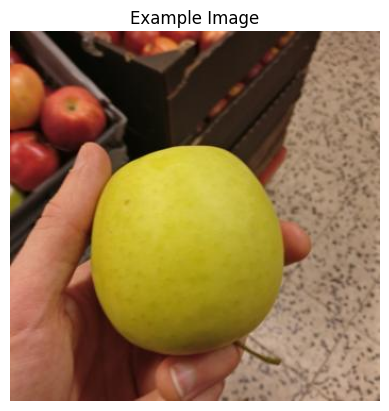

In [8]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Example Image")
plt.axis("off")
plt.show()

In [9]:
df_train["coarse_name"] = df_train["coarse"].map(coarse_mapping)
counts = df_train["coarse_name"].value_counts()

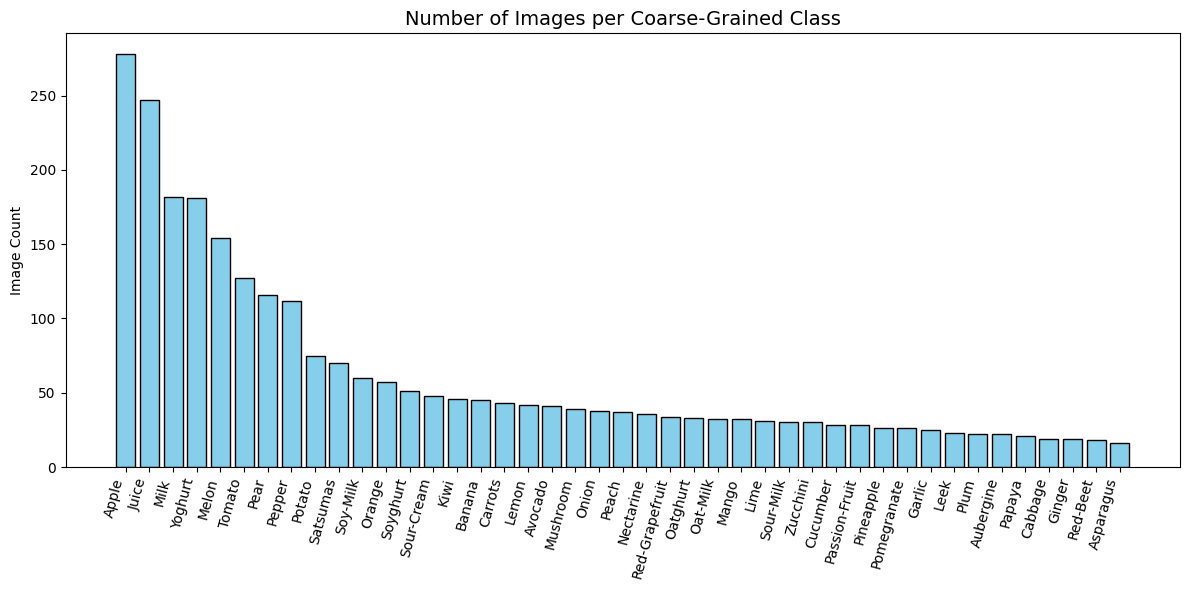

In [10]:
plt.figure(figsize=(12, 6))
plt.bar(counts.index, counts.values, color="skyblue", edgecolor="black")
plt.title("Number of Images per Coarse-Grained Class", fontsize=14)
plt.ylabel("Image Count")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()

# 2. Load Dataset with Train/Val/Test

In [11]:
def load_images_from_folder(paths):
    image_ds = []
    for path in paths:
        s = data_dir + '/' + path
        img = cv2.imread(s)
        resized = cv2.resize(img,img_size)
        image_ds.append(resized)
        
    image_array = np.array(image_ds)
    X = image_array/255
    return X

In [12]:
X_train = load_images_from_folder(df_train['path'].values)
X_val = load_images_from_folder(df_val['path'].values)
X_test = load_images_from_folder(df_test['path'].values)

In [13]:
X_train.shape

(2640, 180, 180, 3)

In [14]:
X_val.shape

(296, 180, 180, 3)

In [15]:
X_test.shape

(2485, 180, 180, 3)

In [16]:
y_train = np.array(df_train['coarse'])
y_val = np.array(df_val['coarse'])
y_test = np.array(df_test['coarse'])

In [17]:
train_counts = dict(zip(counts.index, counts.values))
train_counts

{'Apple': 278,
 'Juice': 247,
 'Milk': 182,
 'Yoghurt': 181,
 'Melon': 154,
 'Tomato': 127,
 'Pear': 116,
 'Pepper': 112,
 'Potato': 75,
 'Satsumas': 70,
 'Soy-Milk': 60,
 'Orange': 57,
 'Soyghurt': 51,
 'Sour-Cream': 48,
 'Kiwi': 46,
 'Banana': 45,
 'Carrots': 43,
 'Lemon': 42,
 'Avocado': 41,
 'Mushroom': 39,
 'Onion': 38,
 'Peach': 37,
 'Nectarine': 36,
 'Red-Grapefruit': 34,
 'Oatghurt': 33,
 'Oat-Milk': 32,
 'Mango': 32,
 'Lime': 31,
 'Sour-Milk': 30,
 'Zucchini': 30,
 'Cucumber': 28,
 'Passion-Fruit': 28,
 'Pineapple': 26,
 'Pomegranate': 26,
 'Garlic': 25,
 'Leek': 23,
 'Plum': 22,
 'Aubergine': 22,
 'Papaya': 21,
 'Cabbage': 19,
 'Ginger': 19,
 'Red-Beet': 18,
 'Asparagus': 16}

In [18]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_names = list(train_counts.keys())

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.2208465785511126,
 1: 1.497447532614861,
 2: 1.3643410852713178,
 3: 1.3346814964610718,
 4: 1.4617940199335548,
 5: 1.9804951237809452,
 6: 1.9186046511627908,
 7: 0.39867109634551495,
 8: 1.7054263565891472,
 9: 1.0771113831089352,
 10: 2.9235880398671097,
 11: 2.1926910299003324,
 12: 1.6593337523570082,
 13: 0.529270248596632,
 14: 2.361359570661896,
 15: 2.7906976744186047,
 16: 2.361359570661896,
 17: 1.8057455540355678,
 18: 0.8770764119601329,
 19: 0.24856416533283118,
 20: 0.337337081523128,
 21: 1.8604651162790697,
 22: 1.9186046511627908,
 23: 1.2790697674418605,
 24: 2.046511627906977,
 25: 1.2038303693570451,
 26: 1.0232558139534884,
 27: 0.3392008223050238,
 28: 3.8372093023255816,
 29: 2.7906976744186047,
 30: 3.2313341493268055,
 31: 1.4277988101676582,
 32: 2.1926910299003324,
 33: 2.4558139534883723,
 34: 3.2313341493268055,
 35: 2.6693629929221436,
 36: 1.5742397137745976,
 37: 1.6156670746634028,
 38: 0.5481727574750831,
 39: 0.8186046511627907,
 40: 3.4108527

# 3. Data Augmentation

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.2),
    #layers.RandomContrast(0.15),
    #layers.RandomBrightness(0.15),
])


I0000 00:00:1761002884.008141  322272 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13680 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:07:00.0, compute capability: 8.9


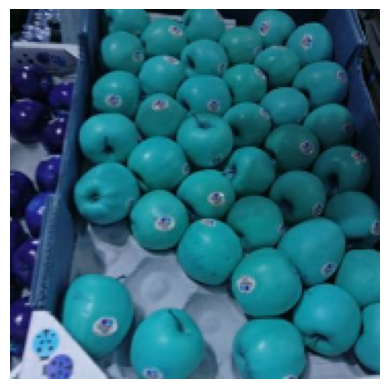

In [20]:
plt.axis('off')
plt.imshow(X_train[10])

2025-10-20 17:28:04.892264: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2052864000 exceeds 10% of free system memory.


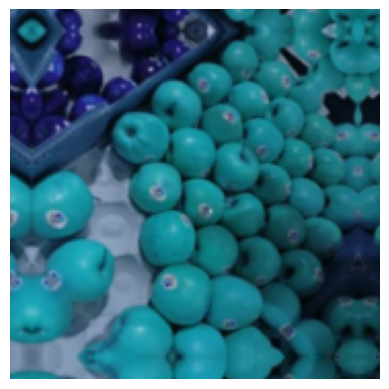

In [21]:
plt.axis('off')
plt.imshow(data_augmentation(X_train)[10])

In [22]:
num_classes = len(coarse_mapping)

# 4. Define CNN Model

In [23]:
model = models.Sequential([
    layers.Input(shape=img_size + (3,)),
    data_augmentation,
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

# 5. Compile Model

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy'
    ]
)

# 6. Train Model

In [25]:
num_epochs = 100

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=num_epochs,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=3)
    ]
)

Epoch 1/100


E0000 00:00:1761002891.610426  322272 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1761002892.178131  322554 cuda_dnn.cc:529] Loaded cuDNN version 91001


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.0388 - loss: 3.8577 - val_accuracy: 0.0777 - val_loss: 3.7283 - learning_rate: 1.0000e-05
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.0389 - loss: 3.8036 - val_accuracy: 0.1149 - val_loss: 3.7048 - learning_rate: 1.0000e-05
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.0488 - loss: 3.7419 - val_accuracy: 0.1047 - val_loss: 3.6632 - learning_rate: 1.0000e-05
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.0648 - loss: 3.5664 - val_accuracy: 0.1284 - val_loss: 3.6409 - learning_rate: 1.0000e-05
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.0594 - loss: 3.6653 - val_accuracy: 0.1588 - val_loss: 3.5988 - learning_rate: 1.0000e-05
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.0642 - loss: 3.6967 - val_accuracy: 0.1655 - val_loss: 3.5839 - learning_rate: 1.0000e-05
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.0739 - los

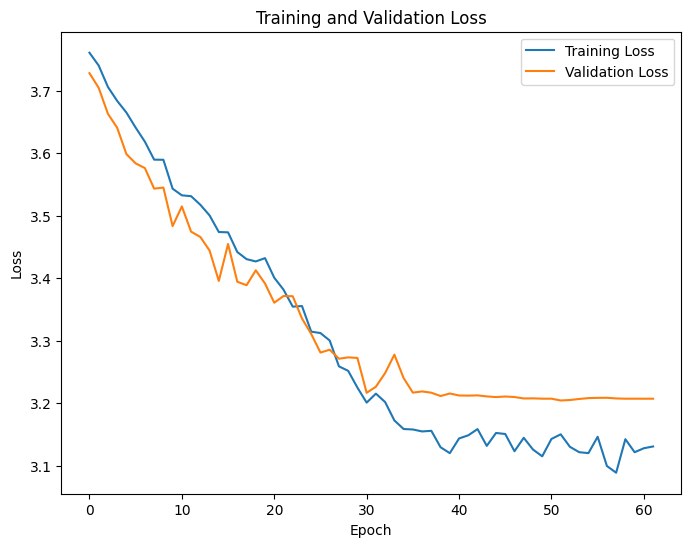

In [26]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 8. F1 Score & Classification Report

In [27]:
y_probs = model.predict(X_test)
y_preds = np.argmax(y_probs, axis=1)

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [28]:
f1 = f1_score(y_test, y_preds, average='weighted')
print(f"\nWeighted F1 Score: {f1:.4f}")


Weighted F1 Score: 0.0981


In [29]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.29      0.01      0.01       276
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        44
           3       0.11      0.24      0.16        45
           4       0.12      0.61      0.19        41
           5       0.18      0.57      0.28        30
           6       0.00      0.00      0.00        31
           7       0.33      0.01      0.01       153
           8       0.00      0.00      0.00        35
           9       0.04      0.07      0.05        56
          10       0.07      0.62      0.13        21
          11       0.00      0.00      0.00        27
          12       0.04      0.06      0.05        36
          13       0.00      0.00      0.00       108
          14       0.00      0.00      0.00        25
          15       0.00      0.00      0.00        22
          16       0.08      0.72      0.15        25
          17       0.15    

/home/gibran/anaconda3/envs/tf219/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gibran/anaconda3/envs/tf219/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gibran/anaconda3/envs/tf219/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

# 9. Confusion Matrix

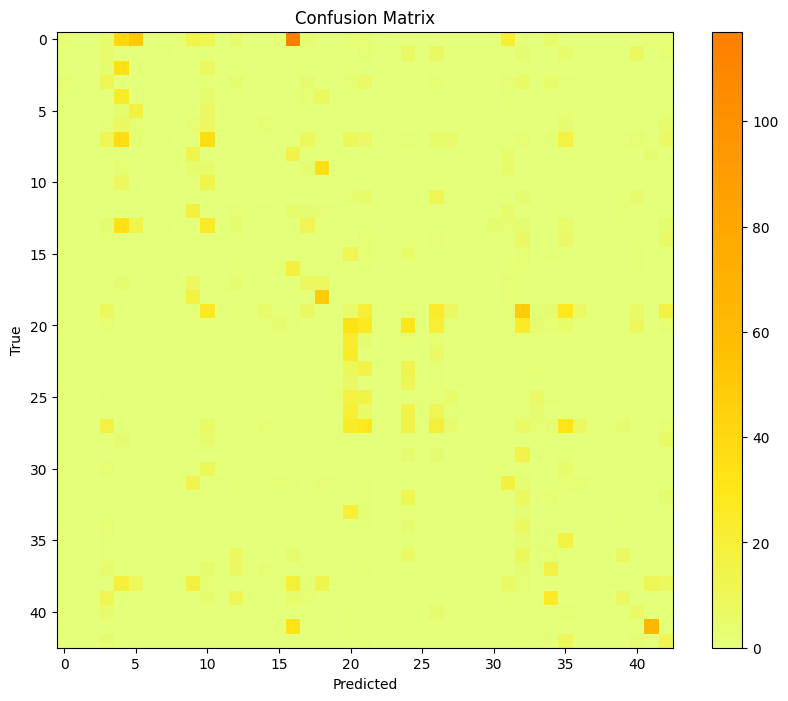

In [30]:
cm = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap='Wistia')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

In [31]:
cm

array([[ 2,  0,  0, ...,  0,  1,  1],
       [ 0,  0,  0, ...,  8,  0,  2],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  6,  0,  1],
       [ 0,  0,  0, ...,  0, 65,  0],
       [ 0,  0,  0, ...,  2,  0, 12]])